<a href="https://colab.research.google.com/github/evan-placenis/NLP/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#getting helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-05-16 13:40:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-16 13:40:45 (117 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



##Get a text dataset

Kaggles text samples of tweets labelled as disaster or not disaster

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

#unzip data
unzip_data("nlp_getting_started.zip")

--2023-05-16 13:40:45--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.198.128, 64.233.191.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.198.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2023-05-16 13:40:45 (143 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [ ]:
#visualizing a text dataset
#NOTE: pandas takes space but this is a small dataset so its small
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
#how many total samples
len(train_df),len(test_df)

(7613, 3263)

In [ ]:
#lets visualize some random samples
import random
#random_index = random.randint(0,len(train_df)-5)
#for row in train_df_shuffled[["text","target"]][random_index:random_index+5].intertuples():
#  _, text, target = row
#  print(f"Target: {target}","(real disaster)" if target > 0 else "(not real disaster)")
#  print(f"Text:\n{text}\n")
#  print("---/n")

In [ ]:
#split data into training and test data set
from sklearn.model_selection import train_test_split

#split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                             train_df_shuffled["target"].to_numpy(),
                                                                             test_size = 0.1, #use 10% of training data for validation
                                                                             random_state = 42)

len(train_sentences),len(train_labels),len(val_sentences),len(val_labels)




(6851, 6851, 762, 762)

#Converting text into numbers


In [ ]:
from string import whitespace
#text vectorization (tokenization)

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = 5000, #how many words in the vocabulary
                                    standardize= "lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, #create groupos of n-words
                                    output_mode = "int",
                                    output_sequence_length = None, #how long a sequence can be (if it shorter than max it pads with zeros))
                                    pad_to_max_tokens = True)

In [ ]:
#find average numer of tokens(words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
max_vocab_length = 10000 #max numbers of words to have in our vocabulary (words outside of it become the same token)
max_length = 15 #max length our sequences wil be

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length=max_length)

In [ ]:
#fit the text vectorizers to the training text ^^
text_vectorizer.adapt(train_sentences)

In [ ]:
#create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"

text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
#get the unique word in the vocab

words_in_vocab = text_vectorizer.get_vocabulary()

top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(top_5_words)
print(bottom_5_words)

['', '[UNK]', 'the', 'a', 'in']
['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:

import random
from tensorflow.keras import layers

tf.random.set_seed(42)
embedding = layers.Embedding(input_dim = max_vocab_length, #set input shape
                             output_dim = 128, #output shape
                             input_length= max_length) #how long each input is
random_sentence = random.choice(train_sentences)
print(f"Origianl text:\n {random_sentence}\
        \n\nEmbedded Version:")

#embed the random sentence (trun it into dense v ectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed


Origianl text:
 1.9 #Earthquake in 5Km S Of Volcano Hawaii #iPhone users download the Earthquake app for more information http://t.co/V3aZWOAmzK        

Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04444983,  0.01861881, -0.02750272, ..., -0.04388705,
         -0.03184102,  0.03408507],
        [-0.0123902 ,  0.03738949,  0.04370684, ...,  0.01402922,
         -0.01731503,  0.01688454],
        [ 0.03416915, -0.00581359,  0.0428056 , ..., -0.02660612,
         -0.04121888,  0.03597717],
        ...,
        [-0.0123902 ,  0.03738949,  0.04370684, ...,  0.01402922,
         -0.01731503,  0.01688454],
        [-0.04375758, -0.03231321,  0.03178756, ..., -0.02461828,
         -0.02768064,  0.03393954],
        [ 0.03468816,  0.0043147 ,  0.0313119 , ..., -0.00551004,
          0.00541537, -0.02817136]]], dtype=float32)>

##Model 0 Baseline - Naive Bayes

In [ ]:
#from sklearn ML map (non Deep learning algorithm) it is machine learning

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create tokenization and modelling pipeline

model0 = Pipeline([
    ("tfidf", TfidfVectorizer()), #convert words to numbers
    ("clf", MultinomialNB()) #model the text
])

model0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#Evaluate the baseline model
baseline_score = model0.score(val_sentences, val_labels)
print(f"Baseline model achieves an accuracy of  {baseline_score*100}%")

#make predications
baseline_preds = model0.predict(val_sentences)
baseline_preds[:20]

Baseline model achieves an accuracy of  79.26509186351706%


array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
#creating an evaluation function to evaluate: accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):#for binary classification
  model_accuracy = accuracy_score(y_true,y_pred)*100
  #weighted avg
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results= {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}

  return model_results



In [ ]:
baseline_results = calculate_results(y_true = val_labels, y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

##Model 1: Simple Dense Model

In [ ]:
#tensorboard callback
from helper_functions import create_tensorboard_callback

#create directory to save logs
SAVE_DIR = "model_logs"




In [ ]:
#build model with function api
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) #inputs are 1-dimensional strings
x = text_vectorizer(inputs)#turn the input x into numbers
x = embedding(x) #create an embeding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) #condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation = "sigmoid") (x) #create the output layer, want binary outputs so use sigmoid function
model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")


In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
#compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(x = train_sentences,
                              y = train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                        experiment_name = "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230516-134050
Epoch 1/5
215/215 [==============================] - 20s 67ms/step - loss: 0.6090 - accuracy: 0.6907 - val_loss: 0.5354 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.4402 - accuracy: 0.8192 - val_loss: 0.4687 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 0.3456 - accuracy: 0.8612 - val_loss: 0.4588 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2841 - accuracy: 0.8923 - val_loss: 0.4640 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2373 - accuracy: 0.9120 - val_loss: 0.4765 - val_accuracy: 0.7887


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4765 - accuracy: 0.7887


[0.47649356722831726, 0.7887139320373535]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.42500657],
       [0.7467429 ],
       [0.9977737 ],
       [0.10697807],
       [0.11349107],
       [0.9374435 ],
       [0.9078925 ],
       [0.99270964],
       [0.9682256 ],
       [0.26624158]], dtype=float32)

In [ ]:
#need to convert prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
#calculate results
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7930566476728028,
 'recall': 0.7887139107611548,
 'f1': 0.7859560656123432}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [ ]:
#visualize learned embeddings

#get the vocabulary from text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()

#get the weight matrix of embedding layer which have been learned for 5 epochs
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

See how we can visualize the embedding matrix with tensorflow projector

In [ ]:
#embedding files from tensorflow website
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
#dowload files from collab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Model 2 LSTM (long short term memory)

input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> output(label probability)

In [ ]:
#create an LSTM MODEL
tf.random.set_seed(42)
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x) #64 is hidden units (use multiple of 8 for GPU speed). When you're stacking RNN cells together, you need to set RS = True
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_LSTM")


In [ ]:
#get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [ ]:

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230516-134128
Epoch 1/5
215/215 [==============================] - 15s 52ms/step - loss: 0.2213 - accuracy: 0.9202 - val_loss: 0.5422 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1603 - accuracy: 0.9404 - val_loss: 0.6117 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1255 - accuracy: 0.9529 - val_loss: 0.7878 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1061 - accuracy: 0.9600 - val_loss: 0.9008 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0829 - accuracy: 0.9648 - val_loss: 1.1038 - val_accuracy: 0.7769


In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)


24/24 [==============================] - 0s 3ms/step


In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = calculate_results(y_true=val_labels, y_pred = model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7798819103655997,
 'recall': 0.7769028871391076,
 'f1': 0.7743498017353971}

##model 3 GRU
another popular and effective RNN component is the GRU or gated recurrent unit

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#x = layers.LSTM(64, return_sequences=True)(x)
#x = layers.GRU(64)(x)
#x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1,activation= "sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_GRU")

model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                      "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230516-134213
Epoch 1/5
215/215 [==============================] - 13s 51ms/step - loss: 0.1582 - accuracy: 0.9367 - val_loss: 0.6622 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0865 - accuracy: 0.9682 - val_loss: 0.8095 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0714 - accuracy: 0.9729 - val_loss: 1.0195 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0663 - accuracy: 0.9737 - val_loss: 1.0459 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0546 - accuracy: 0.9765 - val_loss: 1.0911 - val_accuracy: 0.7730


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_results = calculate_results(y_true = val_labels, y_pred = model_3_preds)
model_3_results

24/24 [==============================] - 0s 5ms/step


{'accuracy': 77.29658792650919,
 'precision': 0.7729426011334698,
 'recall': 0.7729658792650919,
 'f1': 0.7719692225160549}

##Model 4: Bidirectional RNN
Normal RNN go from left to right, bidirectional RNN go both ways

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name = "model_4_bidirectional")
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:
model_4.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
mode_4_history = model_4.fit(train_sentences,
                             train_labels,
                             epochs = 5,
                             validation_data = (val_sentences, val_labels),
                             callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230516-134238
Epoch 1/5
215/215 [==============================] - 16s 52ms/step - loss: 0.1061 - accuracy: 0.9726 - val_loss: 0.9404 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0553 - accuracy: 0.9766 - val_loss: 1.2309 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0473 - accuracy: 0.9783 - val_loss: 1.4287 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0446 - accuracy: 0.9794 - val_loss: 1.3136 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0374 - accuracy: 0.9820 - val_loss: 1.7496 - val_accuracy: 0.7598


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(y_true = val_labels, y_pred = model_4_preds)
model_4_results

24/24 [==============================] - 0s 6ms/step


{'accuracy': 76.50918635170603,
 'precision': 0.7669456967235844,
 'recall': 0.7650918635170604,
 'f1': 0.7627590065822708}

## Model 5: Convolutional Neural Networks for Text
images are usually 2D however text data is 1D

In [ ]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters = 32,
                        kernal_size = 5, #looks at 5 words at a time
                        strides = 1, #default
                        activation = "relu", #
                        padding = "valid") #the output is smaller than the input shape (outside get dropped)
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

In [ ]:
#create 1-dimenstional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64, kernel_size=5, strides = 1, activation = "relu", padding = "valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name = "model_5_Conv1D")

model_5.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [ ]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                      "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230516-140158
Epoch 1/5
215/215 [==============================] - 25s 84ms/step - loss: 0.1222 - accuracy: 0.9599 - val_loss: 0.8772 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0729 - accuracy: 0.9724 - val_loss: 1.0647 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0609 - accuracy: 0.9756 - val_loss: 1.1324 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0546 - accuracy: 0.9784 - val_loss: 1.2222 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0501 - accuracy: 0.9778 - val_loss: 1.2697 - val_accuracy: 0.7612


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred = model_5_preds)
model_5_results

24/24 [==============================] - 0s 4ms/step


{'accuracy': 76.11548556430446,
 'precision': 0.7625228137873495,
 'recall': 0.7611548556430446,
 'f1': 0.7589888106092002}

## Model 6: Transfer Learning in NLP
tensorflow hub pretrained sentence encoder

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.02485911  0.02878049 -0.01271501  0.0397154   0.08827761
  0.02680985  0.05589838 -0.01068731 -0.0059729   0.00639323 -0.01819521
  0.00030817  0.09105889  0.05874642 -0.03180628  0.01512472 -0.05162928
  0.00991366 -0.06865346 -0.04209308  0.0267898   0.03011007  0.00321065
 -0.00337969 -0.04787356  0.02266722 -0.00985928 -0.04063612 -0.01292093
 -0.04666385  0.05630299 -0.03949254  0.00517688  0.02495828 -0.07014439
  0.02871511  0.04947681 -0.00633974 -0.08960193  0.02807117 -0.00808362
 -0.01360602  0.05998651 -0.10361787 -0.05195372  0.00232956 -0.02332529
 -0.03758107  0.0332773 ], shape=(50,), dtype=float32)


In [ ]:
#create a keras layer using the USE pretrained layer from tensorflow
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable=False,
                                        name = "USE")

In [ ]:
#create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128,activation="relu"),
    layers.Dense(1, activation = "sigmoid")
], name = "model_6_USE")

#compile
model_6.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                        "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230516-142736
Epoch 1/5
215/215 [==============================] - 7s 14ms/step - loss: 0.4876 - accuracy: 0.7879 - val_loss: 0.4432 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4088 - accuracy: 0.8167 - val_loss: 0.4308 - val_accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3929 - accuracy: 0.8246 - val_loss: 0.4274 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3832 - accuracy: 0.8298 - val_loss: 0.4229 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3737 - accuracy: 0.8365 - val_loss: 0.4263 - val_accuracy: 0.8202


In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_results = calculate_results(y_true = val_labels,
                                    y_pred = model_6_preds)
model_6_results

24/24 [==============================] - 0s 9ms/step


{'accuracy': 82.02099737532808,
 'precision': 0.8236635567877348,
 'recall': 0.8202099737532809,
 'f1': 0.818424491071347}

##Model 7: same as model 6 but with only 10% of the data
transfer learning really helps when you dont have a large dataset
USES CLONE MODEL

In [ ]:
#BELOW RESULTS IN DATA LEAKAGE
#train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1, random_state = 42)
#train_sentences_10_percent =train_10_percent["text"].to_list()
#train_labels_10_percent =train_10_percent["target"].to_list()
#len(train_labels_10_percent)

#MAKING BETTER DATASET SPLIT (NO DATA LEAKAGE)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

pd.Series(np.array(train_labels_10_percent)).value_counts()#check the number of each label (needs to be roughly equal)

0    406
1    279
dtype: int64

In [ ]:
#create model using the Sequential API
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128,activation="relu"),
    layers.Dense(1, activation = "sigmoid")
], name = "model_7_USE")

model_7.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_7.fit(train_sentences_10_percent,
            train_labels_10_percent,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                    "tf_hub_sentence_encoder_10_percent")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20230516-144116
Epoch 1/5
24/24 [==============================] - 5s 46ms/step - loss: 0.6574 - accuracy: 0.7188 - val_loss: 0.6028 - val_accuracy: 0.8058
Epoch 2/5
24/24 [==============================] - 1s 27ms/step - loss: 0.5581 - accuracy: 0.8055 - val_loss: 0.5041 - val_accuracy: 0.8058
Epoch 3/5
24/24 [==============================] - 1s 28ms/step - loss: 0.4732 - accuracy: 0.8095 - val_loss: 0.4372 - val_accuracy: 0.8202
Epoch 4/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4222 - accuracy: 0.8252 - val_loss: 0.3974 - val_accuracy: 0.8320
Epoch 5/5
24/24 [==============================] - 1s 26ms/step - loss: 0.3893 - accuracy: 0.8305 - val_loss: 0.3688 - val_accuracy: 0.8438


In [ ]:
#OR CAN SIMPILY CLONE THE MODEL
model_7 = tf.keras.models.clone_model(model_6) #cloning model 6

model_7.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_7.fit(train_sentences_10_percent,
            train_labels_10_percent,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                    "tf_hub_sentence_encoder_10_percent_correct_split")])


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20230516-150006
Epoch 1/5
22/22 [==============================] - 4s 50ms/step - loss: 0.6552 - accuracy: 0.7241 - val_loss: 0.6257 - val_accuracy: 0.7507
Epoch 2/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5598 - accuracy: 0.8161 - val_loss: 0.5560 - val_accuracy: 0.7743
Epoch 3/5
22/22 [==============================] - 1s 48ms/step - loss: 0.4729 - accuracy: 0.8175 - val_loss: 0.5051 - val_accuracy: 0.7782
Epoch 4/5
22/22 [==============================] - 1s 54ms/step - loss: 0.4162 - accuracy: 0.8277 - val_loss: 0.4896 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 1s 32ms/step - loss: 0.3803 - accuracy: 0.8453 - val_loss: 0.4829 - val_accuracy: 0.7861


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = calculate_results(y_true = val_labels,
                                    y_pred = model_7_preds)
model_7_results

24/24 [==============================] - 1s 11ms/step


{'accuracy': 78.60892388451444,
 'precision': 0.7864869352962041,
 'recall': 0.7860892388451444,
 'f1': 0.784963205498461}

##Comparing  the performance of each of our models

In [ ]:
#combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percente": model_7_results})

all_model_results = all_model_results.transpose()

In [ ]:
#Reduce the accuracy to the same scale as the other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.788714,0.793057,0.788714,0.785956
2_lstm,0.776903,0.779882,0.776903,0.774350
3_gru,0.772966,0.772943,0.772966,0.771969
4_bidirectional,0.765092,0.766946,0.765092,0.762759
5_conv1d,0.761155,0.762523,0.761155,0.758989
6_tf_hub_use_encoder,0.820210,0.823664,0.820210,0.818424
7_tf_hub_use_encoder_10_percente,0.786089,0.786487,0.786089,0.784963


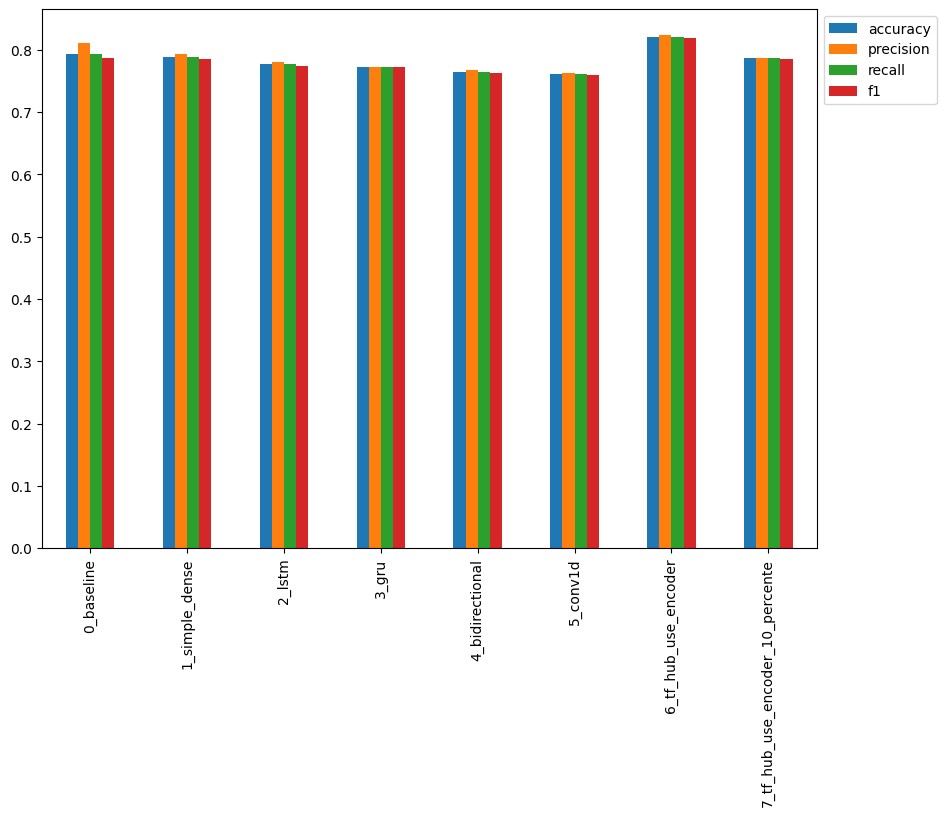

In [ ]:
#plot and compare all model results
all_model_results.plot(kind="bar", figsize = (10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

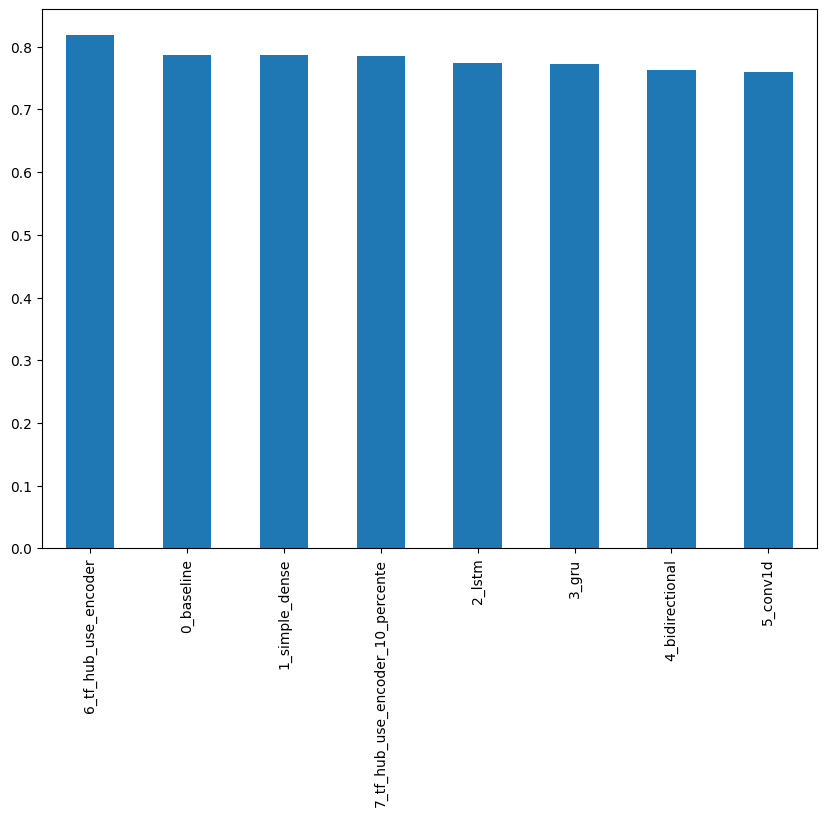

In [ ]:
#sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

##Uploading training logs to TensorBoard.dev

In [ ]:
!tensorboard dev upload --logdir ./model_logs/ \
--name "NLP Modelling Experiments" \
--description "Comparing multiple different types of model architectrues on the Kaggle Tweets text classification dataset"\
--one_shot

2023-05-16 15:32:57.523691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   YQH-GDH-HZS

YQH-GDH-HZS


New experiment created. View your TensorBoard at: https://tensorboar

In [ ]:
#https://tensorboard.dev/experiment/iJr2s1ZNTl6tDKaU3MPV0g/#scalars&_smoothingWeight=0.542&runSelectionState=eyJtb2RlbF8xX2RlbnNlLzIwMjMwNTE2LTEzNDA1MC90cmFpbiI6ZmFsc2UsIm1vZGVsXzFfZGVuc2UvMjAyMzA1MTYtMTM0MDUwL3ZhbGlkYXRpb24iOmZhbHNlLCJDb252MUQvMjAyMzA1MTYtMTQwMTU4L3RyYWluIjp0cnVlLCJDb252MUQvMjAyMzA1MTYtMTQwMTU4L3ZhbGlkYXRpb24iOmZhbHNlLCJtb2RlbF80X2JpZGlyZWN0aW9uYWwvMjAyMzA1MTYtMTM0MjM4L3RyYWluIjpmYWxzZSwibW9kZWxfNF9iaWRpcmVjdGlvbmFsLzIwMjMwNTE2LTEzNDIzOC92YWxpZGF0aW9uIjpmYWxzZSwidGZfaHViX3NlbnRlbmNlX2VuY29kZXIvMjAyMzA1MTYtMTQyNjE5L3RyYWluIjpmYWxzZSwidGZfaHViX3NlbnRlbmNlX2VuY29kZXIvMjAyMzA1MTYtMTQyMjQ3L3ZhbGlkYXRpb24iOmZhbHNlLCJ0Zl9odWJfc2VudGVuY2VfZW5jb2Rlci8yMDIzMDUxNi0xNDI3MzYvdHJhaW4iOmZhbHNlLCJ0Zl9odWJfc2VudGVuY2VfZW5jb2Rlci8yMDIzMDUxNi0xNDI3MzYvdmFsaWRhdGlvbiI6ZmFsc2UsInRmX2h1Yl9zZW50ZW5jZV9lbmNvZGVyLzIwMjMwNTE2LTE0MjI0Ny90cmFpbiI6ZmFsc2V9

In [ ]:
!tensorboard dev list

2023-05-16 15:36:29.729146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/iJr2s1ZNTl6tDKaU3MPV0g/
	Name                 NLP Modelling Experiments
	Description          Comparing multiple different types of model architectrues on the Kaggle Tweets text classification dataset
	Id                   iJr2s1ZNTl6tDKaU3MPV0g
	Created              2023-05-16 15:33:33 (2 minutes ago)
	Updated              2023-05-16 15:33:45 (2 minutes ago)
	Runs                 24
	Tags                 5
	Scalars              360
	Tensor bytes         0
	Binary object bytes  7676585
https://tensorboard.dev/experiment/of7HqKM9Rr213jb9KLwS9w/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   of7HqKM9Rr213jb9KLwS9w
	Created              2023-05-07 19:40:25
	Updated 

##Saving and loading a trained model
1. HDF5
2.SaveModel format (default when using tensorflow)

In [ ]:
model_6.save("model_6.h5") #HDF5 format

In [ ]:
import tensorflow_hub as hub
#load model with custom hub layer (required wiht HDF5 format)
loaded_model_6  = tf.keras.models.load_model("model_6.h5",custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(val_sentences, val_labels)
model_6_results

24/24 [==============================] - 2s 13ms/step - loss: 0.4263 - accuracy: 0.8202


{'accuracy': 82.02099737532808,
 'precision': 0.8236635567877348,
 'recall': 0.8202099737532809,
 'f1': 0.818424491071347}

In [ ]:
#Save model Format
model_6.save("model_6_SavedModel_format")

In [ ]:
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)
model_6_results

24/24 [==============================] - 1s 13ms/step - loss: 0.4263 - accuracy: 0.8202


{'accuracy': 82.02099737532808,
 'precision': 0.8236635567877348,
 'recall': 0.8202099737532809,
 'f1': 0.818424491071347}

##Finding the most wrong examples in the best model
those with prediction probabilites closest to the opposite class

In [ ]:
#download pretrained model from google storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-05-16 15:49:15--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.182.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  80.0MB/s    in 14s     

2023-05-16 15:49:29 (63.8 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.ind

In [ ]:
#import previously trained model from google storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [ ]:
#make predictions
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_results = calculate_results(y_true = val_labels,
                                    y_pred = model_6_pretrained_preds)
model_6_pretrained_results

24/24 [==============================] - 1s 10ms/step


{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [ ]:
#create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
#find the wrong predictions and sort by predction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [ ]:
most_wrong.tail()

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
for row in most_wrong[:10].itertuples():
  _,text,target,pred,pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob:{pred_prob}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0, Pred: 1.0, Prob:0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---

Target: 0, Pred: 1.0, Prob:0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---

Target: 0, Pred: 1.0, Prob:0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---

Target: 0, Pred: 1.0, Prob:0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

---

Target: 0, Pred: 1.0, Prob:0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

---

Target: 0, Pred: 1.0, Prob:0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

Target: 0,

In [ ]:
for row in most_wrong[-10:].itertuples():
  _,text,target,pred,pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob:{pred_prob}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1, Pred: 0.0, Prob:0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

---

Target: 1, Pred: 0.0, Prob:0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

---

Target: 1, Pred: 0.0, Prob:0.054603397846221924
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

---

Target: 1, Pred: 0.0, Prob:0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

---

Target: 1, Pred: 0.0, Prob:0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

---

Target: 1, Pred: 0.0, Prob:0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

---

Target: 1, Pred: 0.0, Prob:0.04208685085

##Making predictions on the test dataset

In [ ]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences,10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("---\n")

1/1 [==============================] - 0s 125ms/step
Pred: 1, Prob 0.9722896814346313
Text:
As California fires rage the Forest Service sounds the alarm about sharply rising wildfire costs http://t.co/ht8FyiMJlR

---

1/1 [==============================] - 0s 70ms/step
Pred: 1, Prob 0.8561450242996216
Text:
Residents artists remember aftermath of Hurricane Katrina through artwork - WDSU New Orleans: WDSU New Orlean... http://t.co/U6pAvbZoB3

---

1/1 [==============================] - 0s 63ms/step
Pred: 0, Prob 0.3176823854446411
Text:
Hp lto-5 lump together warehouse information explosion is more than one divestment able: PMngiqy

---

1/1 [==============================] - 0s 62ms/step
Pred: 1, Prob 0.9673725962638855
Text:
Miners strike; Botha Apartheid SA Tutu Nobel prize; IRA bomb Brighton  Famine in Ethiopia. '84 feels like yesterday http://t.co/UZKssvj9CW

---

1/1 [==============================] - 0s 68ms/step
Pred: 0, Prob 0.12841998040676117
Text:
Today we played mini golf i

Speed Score Tradoff

In [ ]:
#making a funciton to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make a prediction on samples.
  """
  start_time = time.perf_counter() #get start time
  model.predict(samples) #make predictions
  end_time = time.perf_counter() #get fininsh time
  total_time = end_time-start_time #calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model = model_6_pretrained, samples = val_sentences)

print(model_6_total_pred_time, model_6_time_per_pred )

24/24 [==============================] - 0s 18ms/step
0.5738603839999996 0.0007530976167978997


In [ ]:
model_1_total_pred_time, model_1_time_per_pred = pred_timer(model = model_1, samples = val_sentences)

print(model_1_total_pred_time, model_1_time_per_pred)

24/24 [==============================] - 0s 4ms/step
0.2712433950000559 0.00035596246062999463


In [ ]:
model_6_pretrained_results = calculate_results(y_true = val_labels,
                                               y_pred = model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0, 0.5, 'F1-score')

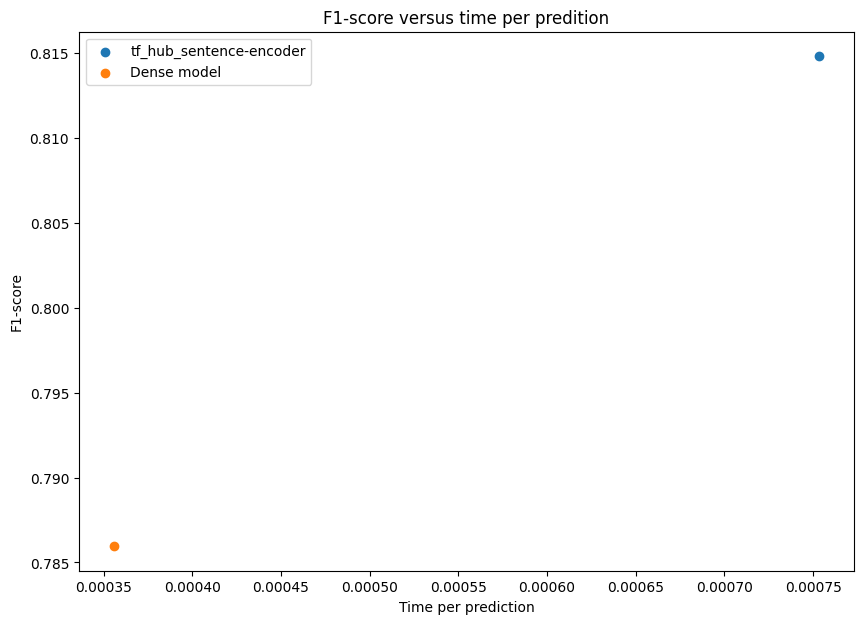

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label = "tf_hub_sentence-encoder")
plt.scatter(model_1_time_per_pred, model_1_results["f1"], label = "Dense model")
plt.legend()
plt.title("F1-score versus time per predition")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")